In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
for batch,label in trainloader:
  print(batch.shape)
  print(label)
  break

torch.Size([64, 3, 32, 32])
tensor([3, 2, 4, 6, 8, 9, 3, 8, 6, 6, 1, 3, 2, 6, 6, 9, 7, 6, 0, 7, 7, 0, 9, 8,
        6, 2, 2, 7, 4, 4, 1, 7, 2, 5, 7, 6, 7, 6, 6, 2, 1, 4, 0, 9, 8, 1, 7, 6,
        5, 2, 9, 6, 5, 2, 3, 7, 8, 9, 1, 6, 0, 6, 1, 6])


# TrainSet is cifar obj includes (img,label)n*1000 times
# But trainloader is batched and shuffled can not be indexed only iterated as batches

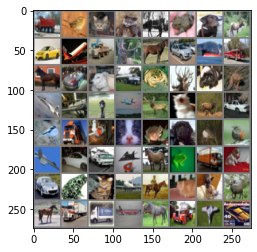

truck  bird   cat   cat


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
print(trainset[0][0])
print(trainset[0][1])

tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  car (1)
torch.Size([3, 32, 32])


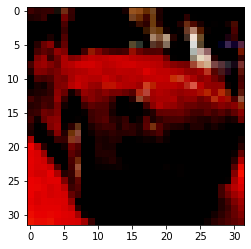

In [108]:
# trainset includes img and labels. When it is batched with dataloader, it will be ready for fitting.
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    # in tensor number of channels loaded first so tensor shape is (3,32,32) so we have used img permute

show_example(trainset[5][0],trainset[5][1])

# Model Prep

In [89]:
import torch.nn as nn
import torch.nn.functional as F

class Util(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
    def accuracy(self,outputs, labels):
      _, preds = torch.max(outputs, dim=1)
      return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        
class Cifar10CnnModel(Util):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
        
        
    def forward(self, xb):
        return self.network(xb)



In [90]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [91]:
model = Cifar10CnnModel()

In [52]:
# takes too long in cpu
#evaluate(model,testloader) 
# result is around %12

#GPU SETTINGS

In [53]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [54]:
device = get_default_device()
device

device(type='cuda')

In [55]:
train_dl = DeviceDataLoader(trainloader, device)
test_dl = DeviceDataLoader(testloader, device)
to_device(model, device);

In [92]:
model = to_device(model, device)

In [57]:
evaluate(model,test_dl)

{'val_acc': 0.10011942684650421, 'val_loss': 2.302938461303711}

In [93]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs,lr,model,train_dl,test_dl,opt_func)

Epoch [0], train_loss: 1.5705, val_loss: 1.1969, val_acc: 0.5586
Epoch [1], train_loss: 1.0482, val_loss: 0.9279, val_acc: 0.6734
Epoch [2], train_loss: 0.7846, val_loss: 0.7909, val_acc: 0.7267
Epoch [3], train_loss: 0.6236, val_loss: 0.7092, val_acc: 0.7603
Epoch [4], train_loss: 0.5055, val_loss: 0.6742, val_acc: 0.7728


In [94]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

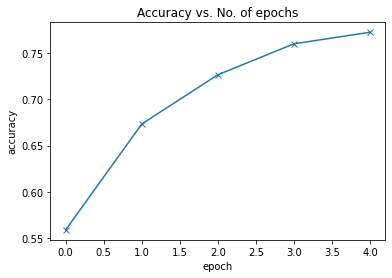

In [95]:
# the fit cell runned twice so it is actuaaly +5 times worked and overfitting has been occured
plot_accuracies(history)

In [96]:
for batch,label in train_dl:
  break
print("img",batch[0])
print("img",label[0])

img tensor([[[-0.9294, -0.9686, -0.9137,  ...,  0.0980,  0.1451,  0.1137],
         [-0.9608, -0.9765, -0.8980,  ...,  0.1137,  0.1529,  0.1529],
         [-0.9608, -0.9608, -0.8667,  ...,  0.1137,  0.1294,  0.1373],
         ...,
         [-0.7490, -0.9059, -0.9529,  ..., -0.4588, -0.4510, -0.4196],
         [-0.7098, -0.8431, -0.9686,  ..., -0.6000, -0.5451, -0.4667],
         [-0.8196, -0.9216, -0.9765,  ..., -0.6941, -0.6078, -0.4980]],

        [[-0.9137, -0.9765, -0.9843,  ...,  0.1529,  0.2000,  0.1686],
         [-0.9216, -0.9686, -0.9686,  ...,  0.1686,  0.2078,  0.2078],
         [-0.9059, -0.9529, -0.9451,  ...,  0.1765,  0.1843,  0.1922],
         ...,
         [ 0.0588,  0.0588,  0.0275,  ..., -0.1765, -0.1843, -0.1373],
         [ 0.1922,  0.1373,  0.0588,  ..., -0.2784, -0.2392, -0.1686],
         [ 0.1529,  0.0824,  0.0588,  ..., -0.3490, -0.2784, -0.1843]],

        [[-0.9137, -0.9843, -0.9843,  ...,  0.2863,  0.3333,  0.3020],
         [-0.9059, -0.9529, -0.9373,  ...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image predicted as : dog
real image is :  horse


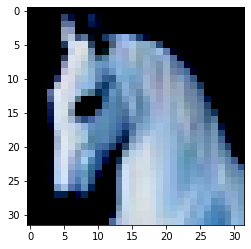

In [129]:

img0 = batch[9]
img0 = img0.unsqueeze(0)
result = F.softmax(model(img0))
index = torch.argmax(result,dim=1)
print("image predicted as :",classes[index])
print("real image is : ",classes[label[9]])
img0 = img0.cpu()
plt.imshow(img0[0].permute(1,2,0))


In [141]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    index = torch.argmax(yb, dim=1)
    print("index : ",index.item())
    # Retrieve the class label
    return classes[index.item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index :  3
Label: cat , Predicted: cat


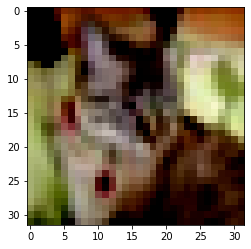

In [144]:
img, label = testset[8]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))